In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.1.2
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [2]:
iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# hold out validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [3]:
best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in [1, 15, 50]: 
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
    if score > best_score:
        best_k, best_score = k, score
    clfs[k] = pipe
    
# performance reporting
y_pred= clfs[best_k].predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' % 
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.9375
[15-NN]
Validation accuracy: 0.90625
[50-NN]
Validation accuracy: 0.4375

Test accuracy: 0.89 (n_neighbors=1 selected by the holdout method)


In [4]:
y_pred= clfs[15].predict(X_test)
print('Test accuracy: %.2f (n_neighbors=15 selected manually)' % 
      accuracy_score(y_test, y_pred))

Test accuracy: 0.91 (n_neighbors=15 selected manually)


In [5]:
iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]: # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
    if scores.mean() > best_score:
        best_k, best_score = k, scores.mean()
    clfs[k] = pipe

[1-NN]
Validation accuracy: 0.895 [0.9047619  0.95238095 0.85714286 0.85714286 0.9047619 ]
[15-NN]
Validation accuracy: 0.895 [0.9047619  0.85714286 0.9047619  0.9047619  0.9047619 ]
[50-NN]
Validation accuracy: 0.819 [0.80952381 0.80952381 0.85714286 0.80952381 0.80952381]


In [7]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' % 
      (accuracy_score(y_test, y_pred), best_k))

Test accuracy: 0.84 (n_neighbors=1 selected by 5-fold CV)


In [8]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in [1, 15, 50]:
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
            X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
            y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


In [9]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors':[1, 15, 50]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))


[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


In [10]:
sigma = 1
n_range = range(10, 50, 2)
k_range = [5, 10]

poly = PolynomialFeatures(degree=2)
X = np.array([])
y = np.array([])
cv5_mean = []
cv5_std = []
cv10_mean = []
cv10_std = []
exp_mean = []
for n in n_range:
    # compute the bias and variance of cv5
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        
        cv5 = KFold(n_splits=5, random_state=None)
        for i, (train, test) in enumerate(cv5.split(X, y)):
            lr = LinearRegression()
            lr.fit(X[train], y[train])
            y_test_pred = lr.predict(X[test])
            mse_test.append(mean_squared_error(y[test], y_test_pred))
    
    cv5_mean.append(np.mean(mse_test))
    cv5_std.append(np.std(mse_test))
    
    # compute the bias and variance of cv10
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        
        cv10 = KFold(n_splits=10)
        for i, (train, test) in enumerate(cv10.split(X, y)):
            lr = LinearRegression()
            lr.fit(X[train], y[train])
            y_test_pred = lr.predict(X[test])
            mse_test.append(mean_squared_error(y[test], y_test_pred))
    
    cv10_mean.append(np.mean(mse_test))
    cv10_std.append(np.std(mse_test))
    
    # compute the expected generalization error of f_N
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        lr = LinearRegression()
        lr.fit(X, y)
        x_test, y_test = gen_data(100, sigma)
        X_test = poly.transform(x_test[:, np.newaxis])
        y_test_pred = lr.predict(X_test)
        mse_test.append(mean_squared_error(y_test, y_test_pred))
    exp_mean.append(np.mean(mse_test))

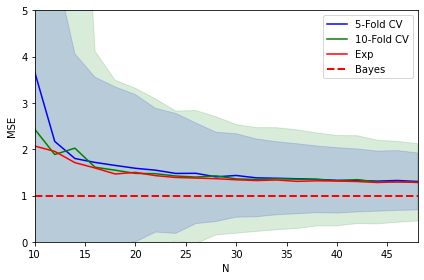

In [11]:
plt.plot(n_range, cv5_mean, 
         markersize=5, label='5-Fold CV', color='blue')
plt.fill_between(n_range,
                 np.add(cv5_mean, cv5_std),
                 np.subtract(cv5_mean, cv5_std),
                 alpha=0.15, color='blue')

plt.plot(n_range, cv10_mean, 
         markersize=5, label='10-Fold CV', color='green')
plt.fill_between(n_range,
                 np.add(cv10_mean, cv10_std),
                 np.subtract(cv10_mean, cv10_std),
                 alpha=0.15, color='green')

plt.plot(n_range, exp_mean, 
         markersize=5, label='Exp', color='red')

plt.hlines(y=sigma, xmin=10, xmax=48, 
           label='Bayes', color='red', 
           linewidth=2, linestyle='--')

plt.legend(loc='upper right')
plt.xlim([10, 48])
plt.ylim([0, 5])
plt.xlabel('N')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('./output/fig-cv-fold.png', dpi=300)
plt.show()

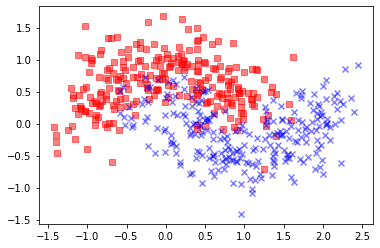

In [12]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0',
            c='r', marker='s', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1',
            c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1],
            c='None', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

In [13]:
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.932 (+/- 0.026)
DecisionTree: 0.943 (+/- 0.026)
KNN: 0.952 (+/- 0.023)


In [14]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.962 (+/- 0.019)
(0, 2, 1): 0.964 (+/- 0.018)
(1, 0, 2): 0.961 (+/- 0.020)
(1, 2, 0): 0.947 (+/- 0.026)
(2, 0, 1): 0.951 (+/- 0.019)
(2, 1, 0): 0.943 (+/- 0.023)

Best (0, 2, 1): 0.964


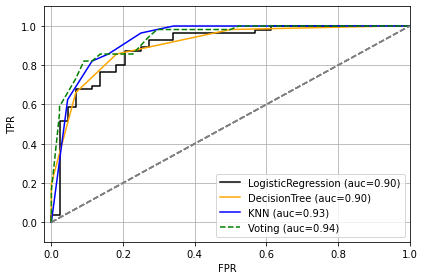

In [15]:
clf_labels =['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 1])
    plt.ylim([-0.1, 1.1])
    plt.grid()
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-vote-roc.png', dpi=300)
plt.show()


/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


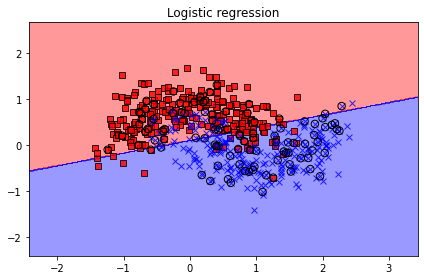

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


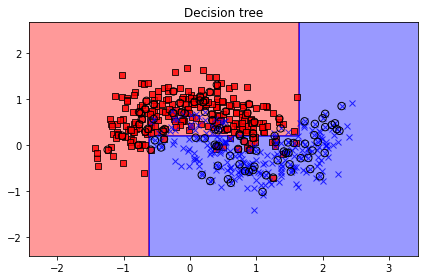

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


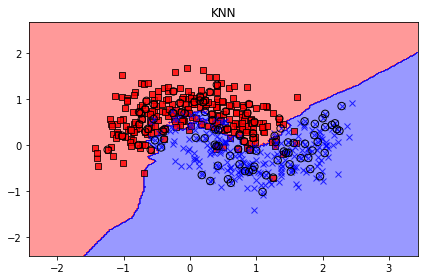

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


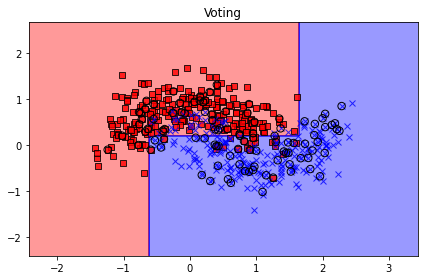

In [16]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe1,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe3,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


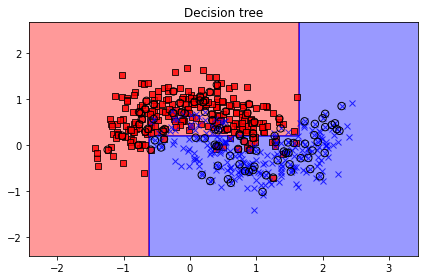

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


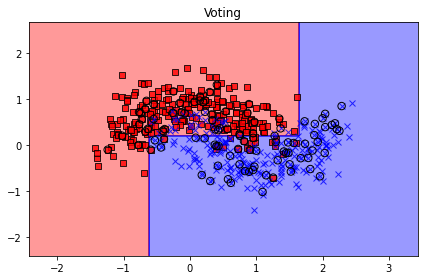

In [17]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary-soft.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary-soft.png', dpi=300)
plt.show()


In [18]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

In [19]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.840
[Bagging] accuracy-train = 0.995, accuracy-test = 0.860


/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


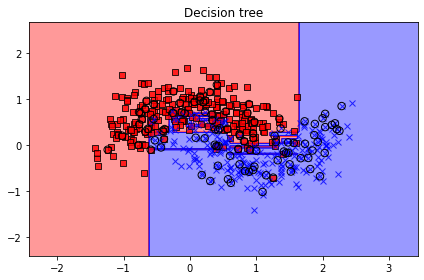

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


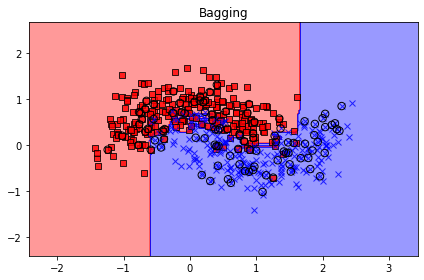

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


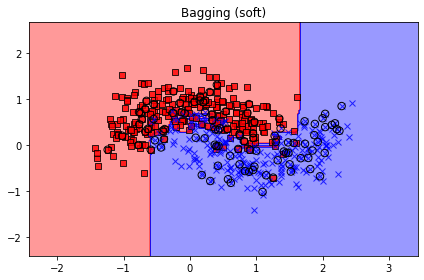

In [20]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-bagging-decision-tree-boundary.png', dpi=300)
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging (soft)')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary-soft.png', dpi=300)
plt.show()

In [21]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.838, accuracy-test = 0.710
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.870


/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


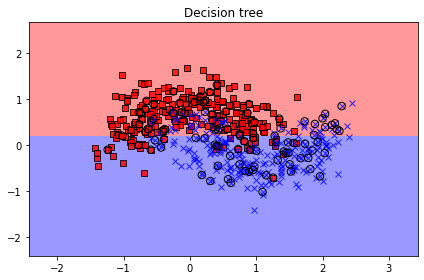

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


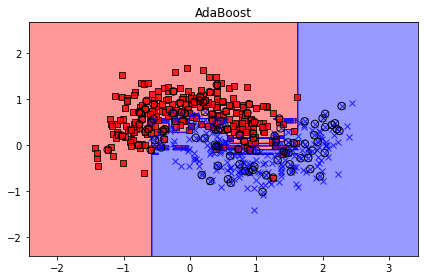

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


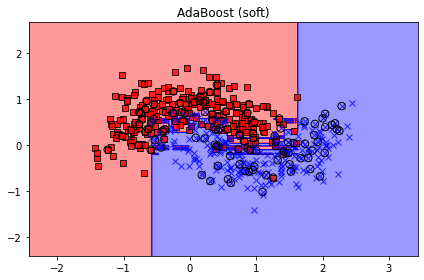

In [22]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary-soft.png', dpi=300)
plt.show()


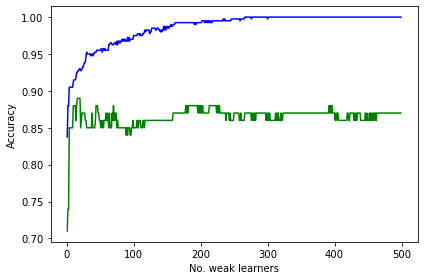

In [23]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()

[AdaBoost16] accuracy-train = 0.925, accuracy-test = 0.890


/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


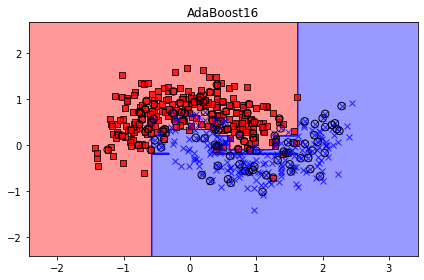

/home/benny/Documents/DL2021/Lab08/lib.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


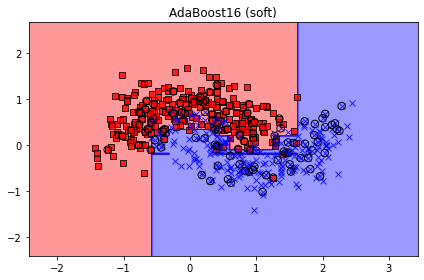

In [25]:
ada16 = AdaBoostClassifier(base_estimator=tree, n_estimators=16)
ada16.fit(X_train, y_train)
y_train_pred = ada16.predict(X_train)
y_test_pred = ada16.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost16] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16')
plt.tight_layout()
plt.savefig('./output/fig-adaboost16-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16 (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost16-boundary-soft.png', dpi=300)
plt.show()

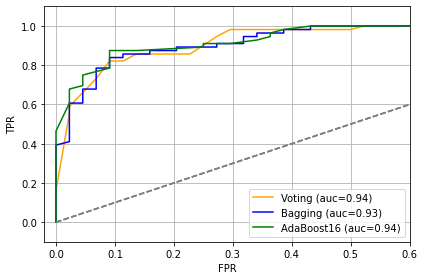

In [26]:
clf_labels =['Voting', 'Bagging', 'AdaBoost16']
colors = ['orange', 'blue', 'green']
linestyles = ['-', '-', '-']
for clf, label, clr, ls in zip([best_vt, bag, ada16], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 0.6])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-ensemble-roc.png', dpi=300)
plt.show()